# **Image Generation with Autoencoders, Variational Autoencoders, and GANs**

## Setup

### 1.   Dataset Preparation
First, all the images need to be transformed to be tensors for future purpose, here with additional normalization.

Besides, I choose the panda [dataset](https://quickdraw.withgoogle.com/data/panda) from QuickDraw, and all the drawings have been rendered into a 28x28 grayscale bitmap in numpy format, so I need to preprocess them to be PyTorch dataset for DataLoader to load into.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage
# Progress bar
from tqdm.notebook import tqdm
# PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
from matplotlib.ticker import MaxNLocator
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import random


# set random seeds
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

# Apply transformations on images to make them become a tensor also with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


# Convert npy dataset to PyTorch dataset for loading into DataLoader
class QUICKDRAW(torch.utils.data.Dataset):
    def __init__(self, path, reshape=False):
        if reshape is True:
            self.data = np.load(path).reshape((-1, 28, 28))
        self.data = np.load(path)
        self.transforms = transform

    def __getitem__(self, index):
        hdct = self.data[index, :, :]
        hdct = np.squeeze(hdct)
        ldct = 2.5 * skimage.util.random_noise(hdct * (0.4 / 255), mode='poisson', seed=None) * 255  # add poisson noise
        hdct = Image.fromarray(np.uint8(hdct))  # convert to image format
        ldct = Image.fromarray(np.uint8(ldct))  # convert to image format
        hdct = self.transforms(hdct)  # transform to tensor
        ldct = self.transforms(ldct)  # transform to tensor
        return ldct, hdct

    def __len__(self):
        return self.data.shape[0]  # total number of data

### 2.   Load Dataset
At the original dataset, it has over 100K images, so I splite dataset into a smaller one which has 50K images. Besides, I split the data into three different folds: 70% for training, 15% for validation, and 15% for testing. At last, I load those data sets into DataLoader to train and test model.

In [ ]:
def loadData(path="./data_npy/panda.npy"):
    dataset = QUICKDRAW(path)
    #  Create a smaller subset of the original dataset
    dataset = data.Subset(dataset, np.arange(50000))

    #  Split the data : 70% for training, 15% for validation, and 15% for testing
    train_set, val_test = data.random_split(dataset, [35000, 15000])
    val_set, test_set = data.random_split(val_test, [7500, 7500])

    # Define data loaders to iterate over datasets
    train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True,
                                   num_workers=4)
    val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
    test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
    return train_loader, val_loader, test_loader

train_loader, _, _ = loadData()

### 3.   Plotting Results and Samples
First function here is from previous assignments to plot multiple experiments data.

Second one is to compare the original image with the reconstructed image visually, also showing the improvement of results as training goes.

Third one is to plot samples generated from various models.

In [ ]:
def multi_plot_data(results, names, title1='', title2=''):
    x = np.arange(len(results[0]))
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for i, y in enumerate(results):
        plt.plot(x + 1, y, '-', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 16}, numpoints=10, title=title1)
    plt.xlabel('Epochs')
    plt.ylabel('Reconstruction error')
    ax.set_title(title2)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()


def compare_imgs(results, title=None, stride=1):
    count = 0
    num_plots = 2 * (num_epochs - stride + 1)
    plt.figure(figsize=(9, num_plots))
    plt.gray()
    for k in range(0, num_epochs, stride):
        imgs = results[k][1].detach().numpy()
        recon = results[k][2].detach().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            count += 1
            plt.subplot(num_plots, 9, count)
            item = item.reshape(-1, 28, 28)
            # item: 1, 28, 28
            plt.imshow(item[0])

        for i, item in enumerate(recon):
            if i >= 9: break
            count += 1
            plt.subplot(num_plots, 9, count)
            item = item.reshape(-1, 28, 28)
            # item: 1, 28, 28
            plt.imshow(item[0])
    if title is not None:
        plt.suptitle("Latent dimensionality: %d" % title)
    plt.show()


def plot_samples_grid(in_, n_rows=8, n_cols=8, fig_size=8, img_dim=28, title=None):
    f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

    in_pic = in_.data.data.cpu().view(-1, 28, 28)
    for i, ax in enumerate(axarr.flat):
        ax.imshow(in_pic[i])
        ax.axis('off')

    plt.suptitle(title)
    plt.show()

## Autoencoders
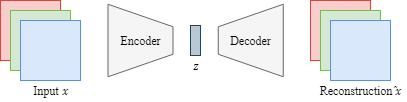

An autoencoder consists of an encoder that maps the input to a lower-dimensional feature vector, and a decoder that reconstructs the input.


### 1.   Implement model

The encoder consists of a deep convolutional network which can scale down the image layer-by-layer to a feature vector with selected latent dimension. And for the decoder, the only difference is that we replace strided convolutions by transposed convolutions to reconstruct the image using feature vector from encoder. However, to truly have a reverse operation of the convolution, we need to ensure that the layer scales the input shape correctly by specifying the parameter **output_padding** which adds additional values to the output shape as shown below. 




> image.png



In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int, atype: int, act_fn=nn.GELU):
        super().__init__()
        input_channels = 1
        c_hid = 32
        self.type = atype

        # Autoencoder 1
        if self.type == 1:
            self.encoder = nn.Sequential(
                nn.Conv2d(input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 1x28x28 => 32x14x14
                act_fn(),
                nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
                act_fn(),
                nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 32x14x14 => 64x7x7
                act_fn(),
                nn.Flatten(),  # 64x7x7 => (7x7x64)x1x1
                nn.Linear(2 * 49 * c_hid, latent_dim)  # (7x7x64)x1x1 => (latent_dim)x1x1
            )

            self.linear = nn.Sequential(
                nn.Linear(latent_dim, 2 * 49 * c_hid),  # (latent_dim)x1x1 => (7x7x64)x1x1
                act_fn()
            )

            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(2 * c_hid, c_hid, 3, output_padding=1, padding=1, stride=2),  # 64x7x7 => 32x14x14
                act_fn(),
                nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
                act_fn(),
                # 32x14x14=> 1x28x28
                nn.ConvTranspose2d(c_hid, input_channels, 3, output_padding=1, padding=1, stride=2),
                nn.Tanh()  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
            )

        # Autoencoder 2
        if self.type == 2:
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2),  # 1x28x28 => 32x14x14
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),  # 32x14x14 => 64x7x7
                nn.ReLU(),
                nn.Conv2d(64, latent_dim, kernel_size=7))  # 64x7x7 => (latent_dim)x1x1

            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(latent_dim, 64, kernel_size=7),  # (latent_dim)x1x1 => 64x7x7
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, stride=2, output_padding=1),  # 64x7x7 => 32x14x14
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, stride=2, output_padding=1),  # 32x14x14 => 1x28x28
                nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        if self.type == 1:
            x = self.linear(x)
            x = x.reshape(x.shape[0], -1, 7, 7)  # (7x7x64)x1x1 => 64x7x7
        x_hat = self.decoder(x)
        return x_hat

    def sample(self, n_samples):
        z = torch.randn((n_samples, self.latent_dim)).cpu()
        if self.type == 1:
            z = self.linear(z)
            z = z.reshape(z.shape[0], -1, 7, 7)  # (7x7x64)x1x1 => 64x7x7
        return self.decoder(z)

### 2.   Train the model
Foe the training process, it have two parts: forward and backward. Here I use mean squared error as loss function to measure the distance between original pixel value with reconstructed one pushing the network to pay special attention to those pixel values its estimate is far away. 

In [ ]:
num_epochs = 5


def train(latent_dim, atype):
    outputs = []
    model = Autoencoder(latent_dim, atype).cpu()
    distance = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
    for epoch in range(num_epochs):
        for trains in train_loader:
            img, _ = trains
            img = torch.reshape(img, (256, 1, 28, 28))
            img = Variable(img).cpu()
            # print(np.shape(img))
            # ===================forward=====================
            output = model(img)
            loss = distance(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
        outputs.append((epoch, img, output, loss.item()))
    # save the state dict of the model
    torch.save(model.state_dict(), 'ae-model.pt')
    return outputs

### 3.   Compare latent dimensionality
In an autoencoder, we need to choose the dimension of feature vector also called latent dimension. Theoretically the higher the latent dimensionality, the better we expect the reconstruction to be. However, we also need to consider trade-off between compression and quality. Thus, here I train the model with different latent dimensionalities to find the best trade-off.

In [ ]:
def experiment1():
    losses = []
    dims = []
    for latent_space in [64, 128, 256, 384]:
        loss = []
        result = train(latent_space, 1)
        if latent_space >= 128:
            compare_imgs(result, latent_space)
        for k in range(num_epochs):
            loss.append(result[k][3])
        losses.append(loss)
        dims.append(latent_space)
    multi_plot_data(losses, dims, 'Latent dimensionality', 'Autoencoders with different latent space')

In [ ]:
experiment1()

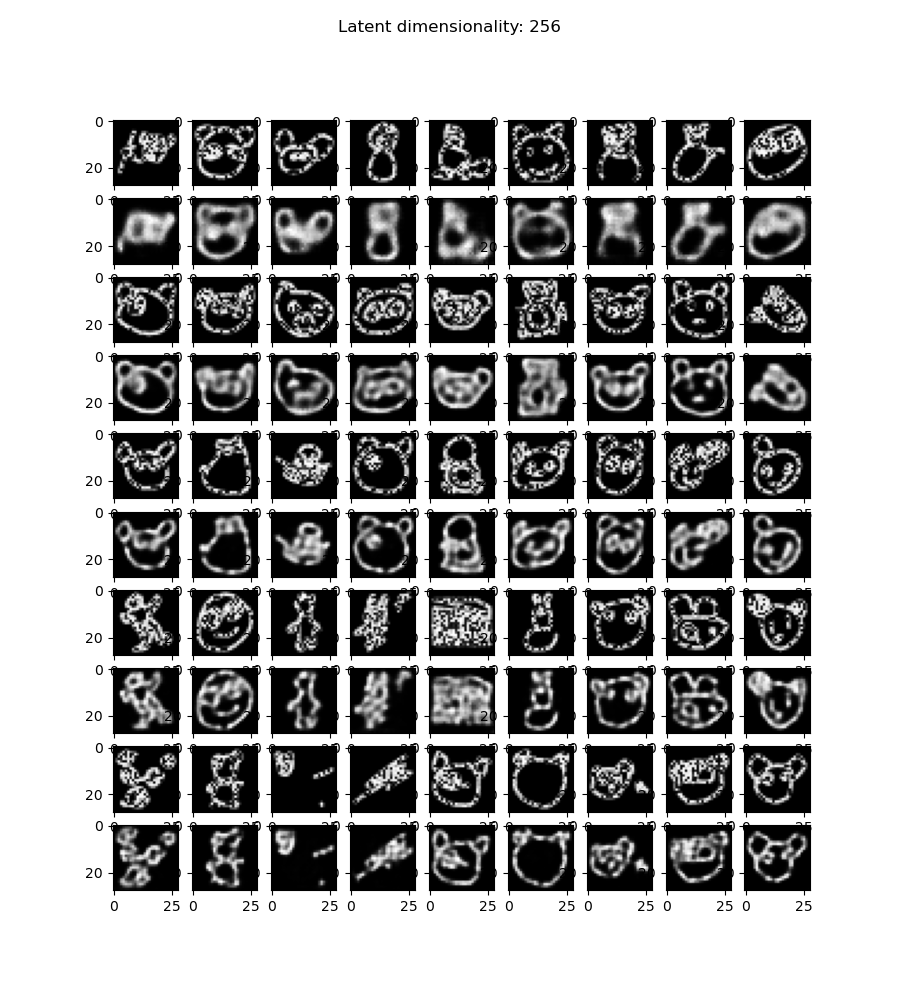

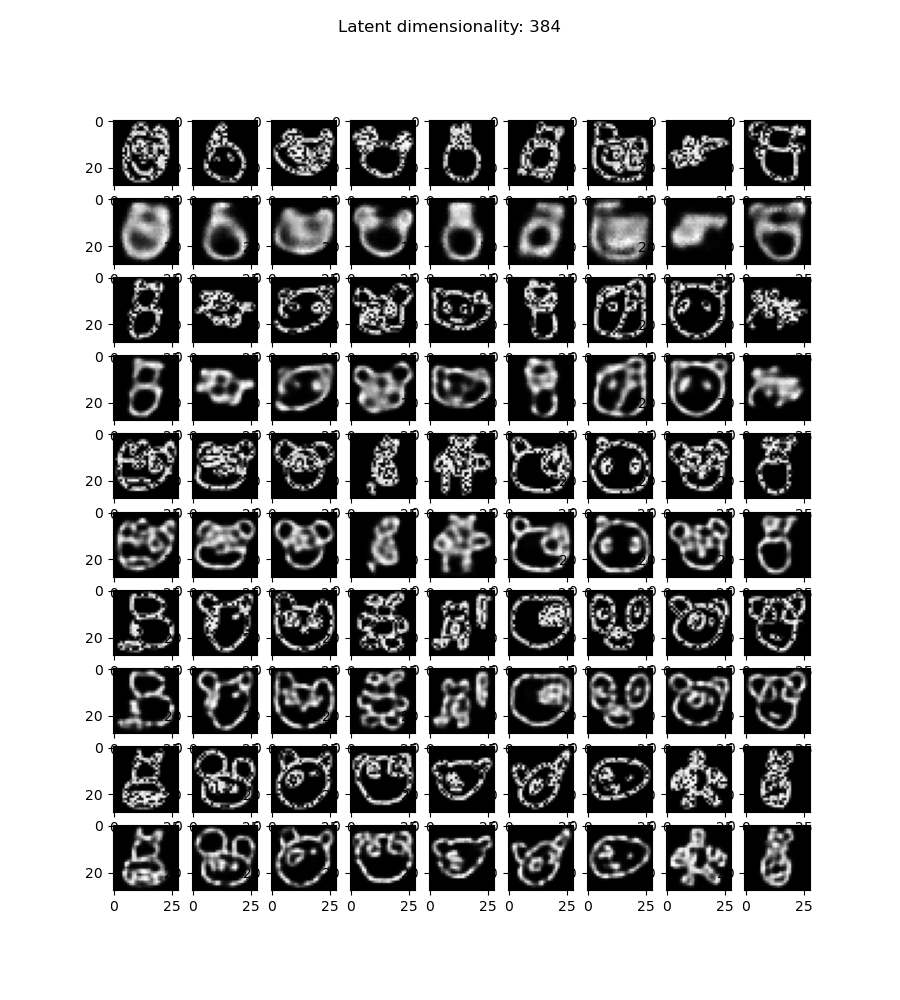

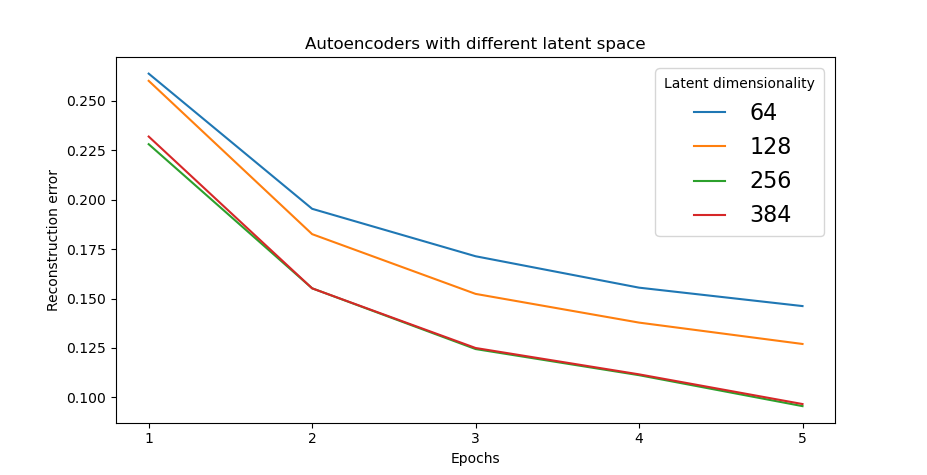

As shown above, the reconstruction of images goes better with loss going down as training goes. Besides, as we expected, with increasing latent dimensionality the reconstruction error goes down. However, from visually comparison and last chart we can see that there is not that much improvement between the model with the highest two latent dimensionalities compared with the smallest two latent dimensionalities. Thus, the model with **256** latent space has best trade-off between compression and quality.

### 4.   Compare network architecture
In the implementation of the model, it consists of models with different network architecture (basically different activation function). Here I choose the size of the latent space as 256 which is proved to be best latent dimensionality to compare the performance of those two models.

In [ ]:
def experiment2():
    losses = []
    names = []
    for nntype in [1, 2]:
        loss = []
        result = train(256, nntype)
        for k in range(num_epochs):
            loss.append(result[k][3])
        losses.append(loss)
        names.append(nntype)
    multi_plot_data(losses, names, 'Network Architecture', 'Autoencoders with different network architecture')

In [ ]:
experiment2()

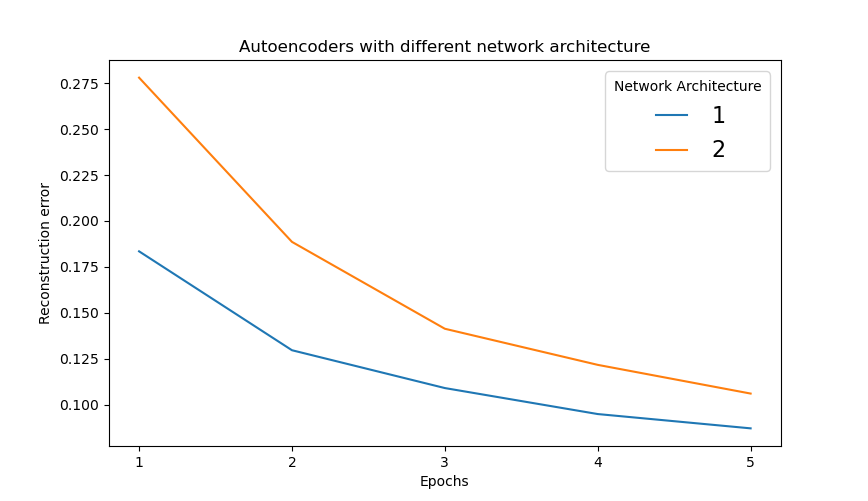

As shown above, the model with first network architecture performed better as it has lower reconstruction error.

### 5.   Generate fake images

In [ ]:
model = Autoencoder(256, 1).cpu()
train(256, 1)
# loading a trained module
model.load_state_dict(torch.load('ae-model.pt'))
samples = model.sample(64)
plot_samples_grid(samples)

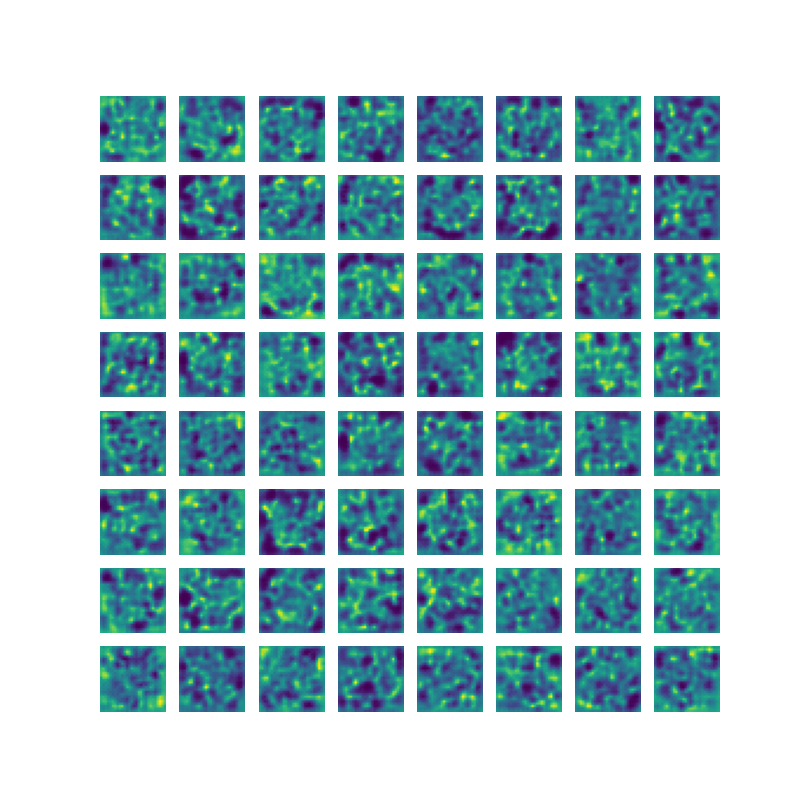

As we can see from previous section that AEs can reconstruct images pretty good, but this time it didn't generate fake images as we expected. Since AEs make the latent space in whichever way it suits the reconstruction best, it **can't map a random latent** vector to an image as we want.


### 6.   Conclusion
The model with **256 latent space** and **network architecture 1** gives the best trade-off between compression and quality.

However, AEs are indeed **not generative**, it cannot generate new images when putting random latent vector into decoder.



---


## Variational Autoencoders (VAEs)

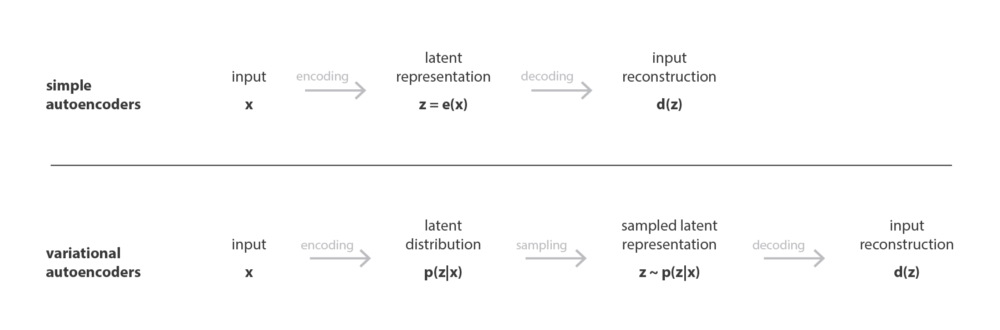



*   Although VAE has “Autoencoders” in its name, VAEs and AEs are very different:
  1.   The encoder of VAE comprises two things: $E(z)$ and $V(z)$ where $z$ is the latent random variable following a Gaussian distribution (other distributions can be used as well) with mean $E(z)$ and variance $V(z)$. 
  2.   The latent random variable $z$ is sampled from a **sampler** which is  from the above distribution parametrized by the encoder.
  3.   The decoder reconstructs the input by $z$.


*   As shown below, the loss function is quite different as well. Since the main idea of VAE is to enforce some structure to the latent space instead of fixed latent space at AEs, the loss function is therefore composed of a reconstruction loss as well as a **regularization term**. The reconstruction loss is the same as AEs, and the regularization term is a penalty term using KL-divergence to estimate the distance between two distributions. ($\beta$ is used for latent space disentanglement)

$$l(x, \hat x) = l_{reconstruction} + \beta l_{KL}(z, \mathcal{N}({0}, {I}_d))$$


*   According to above, $z$ is sampled from the Gaussian distribution, so we cannot do backpropagation through the sampling module to do gradient descent. Thus, we use the **reparameterization trick** to “sample” $z$. We use $z = E(z) + \epsilon ⊙ \sqrt{V(z)}$ where $\epsilon\sim\mathcal{N}({0}, {I}_d)$ to make the gradient descent possible despite the random sampling.






### 1.   Implement model

In [ ]:
# Keep the pixel values between [0, 1] to use BCE
transform = transforms.Compose([transforms.ToTensor()])
train_loader, _, test_loader = loadData()


class VAE(nn.Module):
    def __init__(self, latent_size: int, vtype: str):
        super().__init__()
        self.latent_size = latent_size
        self.type = vtype

        if self.type == 'Linear':
            self.encoder = nn.Sequential(
                nn.Linear(784, 128),
                nn.ReLU(),
                nn.Linear(128, latent_size * 2)
            )

            self.decoder = nn.Sequential(
                nn.Linear(latent_size, 128),
                nn.ReLU(),
                nn.Linear(128, 784),
                nn.Sigmoid(),
            )

        if self.type == 'Conv':
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2),  # 1x28x28 => 32x14x14
                nn.GELU(),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.GELU(),
                nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),  # 32x14x14 => 64x7x7
                nn.GELU(),
                nn.Flatten(),  # 64x7x7 => (7x7x64)x1x1
                nn.Linear(49 * 64, latent_size * 2)  # (7x7x64)x1x1 => (latent_size * 2)x1x1
            )

            self.linear = nn.Sequential(
                nn.Linear(latent_size, 49 * 64),  # (latent_size)x1x1 => (7x7x64)x1x1
                nn.GELU()
            )

            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 3, output_padding=1, padding=1, stride=2),  # 64x7x7 => 32x14x14
                nn.GELU(),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.GELU(),
                # 32x14x14=> 1x28x28
                nn.ConvTranspose2d(32, 1, 3, output_padding=1, padding=1, stride=2),
                nn.Sigmoid()  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
            )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        if self.type == 'Linear':
            x = x.view(-1, 784)
        if self.type == 'Conv':
            x = x.view(-1, 1, 28, 28)
        mu_logvar = self.encoder(x).view(-1, 2, self.latent_size)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        return mu, logvar

    def decode(self, z):
        if self.type == 'Conv':
            z = self.linear(z)
            z = z.reshape(z.shape[0], -1, 7, 7)  # (7x7x64)x1x1 => 64x7x7
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
        z = torch.randn((n_samples, self.latent_size)).to(device)
        return self.decode(z)


# Reconstruction + KL divergence losses
def loss_function(x_hat, x, mu, logvar):
    # reconstruction loss
    BCE = nn.functional.binary_cross_entropy(
        x_hat.view(-1, 784), x.view(-1, 784), reduction='sum'
    )

    # regularization term using KL-divergence
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD  # we can use a beta parameter here (BCE + beta * KLD)

### 2.   Train the model and Evaluate on the testset
Here I use test set to evaluate the performance of the model.

In [ ]:
def train(latent_size, vtype):
    model = VAE(latent_size, vtype).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    outputs = []
    for epoch in range(num_epochs):
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss = train_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch + 1} Average train loss: {loss:.4f}')
        test_loss, test_x, test_x_hat, means, logvars, labels, images = test(model)
        print(f'====> Epoch: {epoch + 1} Average test loss: {test_loss:.4f}')
        outputs.append((epoch, test_x, test_x_hat, test_loss))
    return outputs, means, logvars, labels, images, model


def test(model):
    means, logvars, labels, images = list(), list(), list(), list()
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for x, y in test_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # log
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
            images.append(x.detach())
    test_loss = test_loss / len(test_loader.dataset)
    return test_loss, x, x_hat, means, logvars, labels, images

### 3.   Comparing latent dimensionality


In [ ]:
def experiment3():
    losses = []
    sizes = []
    for latent_space in [64, 128, 256, 384]:
        loss = []
        result = train(latent_space, 'Conv')
        if latent_space >= 128:
            # compare the first image and last image during training
            compare_imgs(result, latent_space, num_epochs - 1)
        for k in range(num_epochs):
            loss.append(result[k][3])
        losses.append(loss)
        sizes.append(latent_space)
    multi_plot_data(losses, sizes, 'Latent dimensionality', 'VAEs with different latent space')

In [ ]:
experiment3()

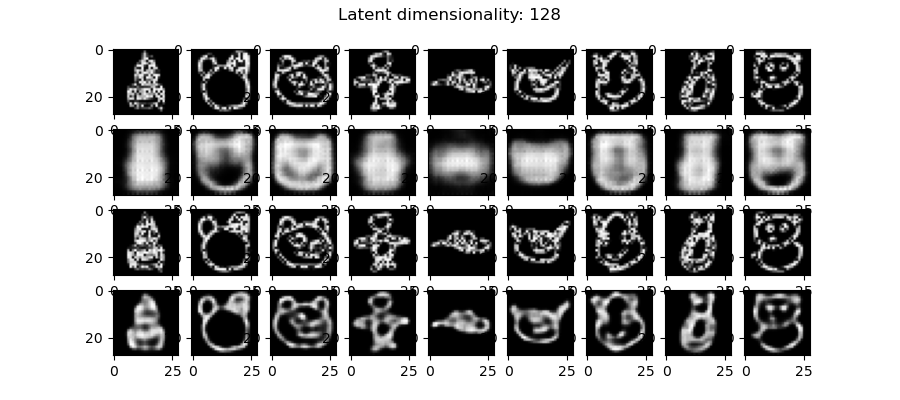

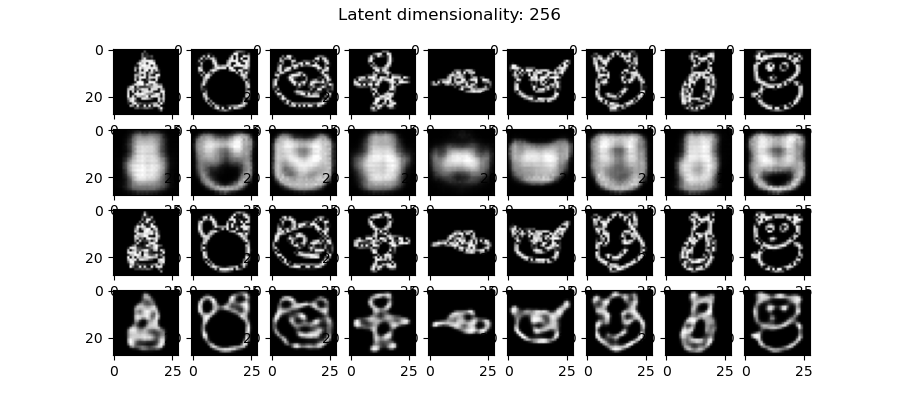

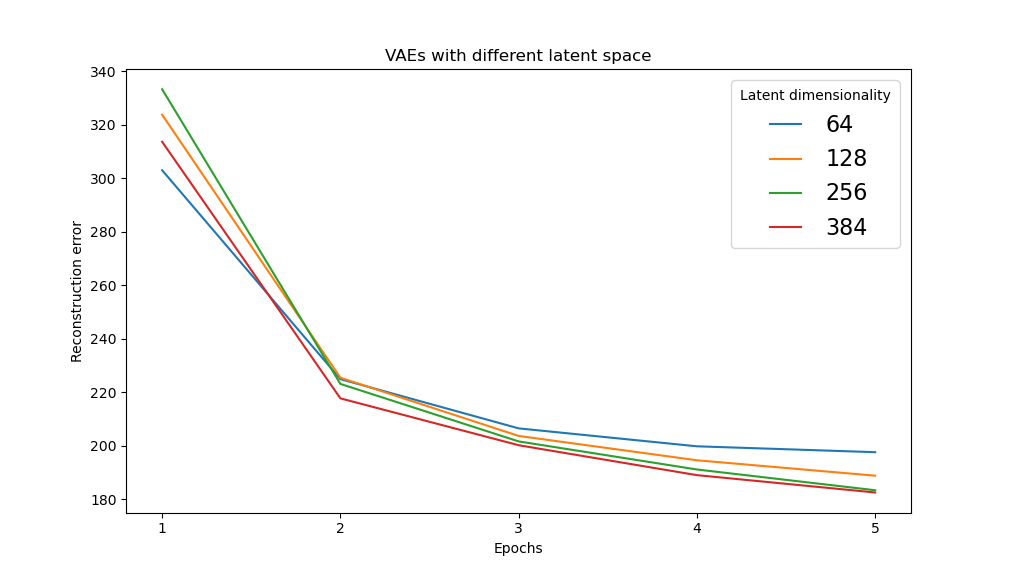

As shown above, the model with 128, 256 and 384 latent space performed better as they have lower reconstruction error. Considering the trade-off between compression and quality, the best choice of latent space is **256**.

### 4.   Comparing network architecture
In the implementation of the model, it consists of models with two network architectures: linear network and convolutional network.

In [ ]:
def experiment4():
    losses = []
    names = []
    for nntype in ['Linear', 'Conv']:
        loss = []
        result = train(256, nntype)
        for k in range(num_epochs):
            loss.append(result[k][3])
        losses.append(loss)
        names.append(nntype)
    multi_plot_data(losses, names, 'Network Architecture', 'VAEs with different network architecture')

In [ ]:
experiment4()

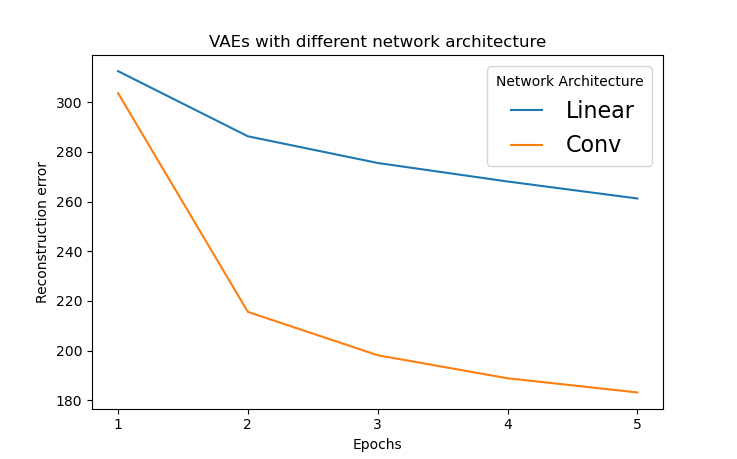

As shown above, the model with **convolutional** network architecture performed better as it has lower reconstruction error.

### 5.   Generate fake images
Since VAEs can enforce some structure to the latent space, different regions in the latent space can generate different style of fake images.

In [ ]:
latent = 128
codes = dict(μ=list(), logσ2=list(), y=list(), x=list())
_, means, logvars, labels, images, model = train(latent, 'Conv')
# log for analysis
codes['μ'].append(torch.cat(means))
codes['logσ2'].append(torch.cat(logvars))
codes['y'].append(torch.cat(labels))
codes['x'].append(torch.cat(images))
# different regions in latent space and the number of fake images
A, B, N = 10, 20, 64
code = torch.Tensor(N, latent).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
  # interpolation of the two latent vectors
  code[i] = i / (N - 1) * codes['μ'][0][B].data + (1 - i / (N - 1)) * codes['μ'][0][A].data
sample = model.decode(code)
plot_samples_grid(sample)

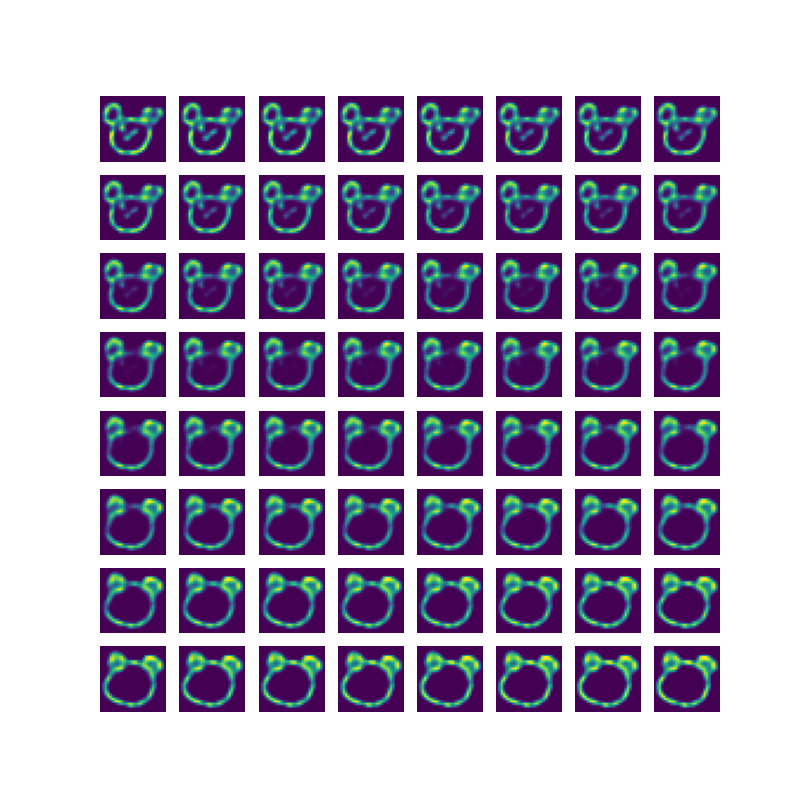

As shown above, the images of first row has a different style compared with last row, but both can recognize to be the type of images we want.

### 6.   Conclusion
The model with **128 latent space** and **convolutional network architecture** gives the best trade-off between compression and quality.

Besides, VAEs are indeed **generative**, it can generate different style of images when putting the latent vector in different regions into decoder.



---


## Generative Adversarial Networks (GANs)



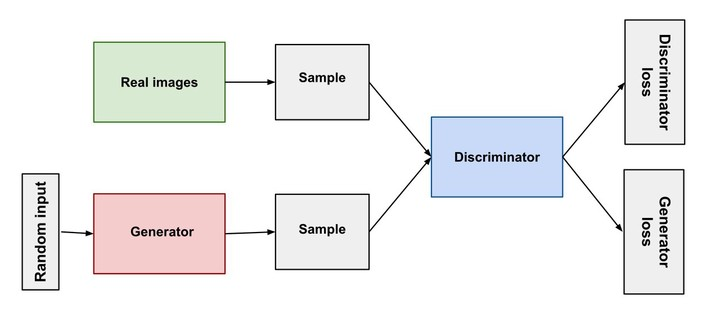

Compared to VAEs discussed above, GANs create generators slightly differently. As VAEs use the reconstruction loss to push the input image and reconstructed image to be similar, GANs train through **an adversarial network** with the generator and discriminator competing. In other word, we are training two neural networks at the same time through backpropagation through gradient based methods.

Besides, there are some challenges of GANs:


1.   **Unstable convergence**: as the generator's performance getting better with training, the discriminator can no longer easily figrue out the real and fake data. Thus, the discriminator feedback gets less meaningful over time, and GANs cannot converge to a stable state.
2.   **Vanishing gradient**: as the discriminator becomes more confident, which makes outputs of the discriminator into flatter regions hindering the training generator network. Thus, make sure that the cost gradually increases as becoming more confident (e.g., using ReLU).
3.   **Mode collapse**: if a generator can fool the discriminator with a single output, it will always generate that one. Eventually, the discriminator will learn to detect specifically this fake input, and the generator will simply finds the next most plausible output. As a result, the discriminator gets trapped in local minima. To solve this issue, we need to enforce some penalty to the generator for always giving the same output given different inputs.



### 1.   Implement DCGANs (Deep Convolution Generative Adversarial Networks)
First, here I use **argparse** to set parameters for GANs' training. Besides, I define a new dataloader containing 32K samples to train GANs.

In [ ]:
import argparse
import os
import random
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.utils as vutils

parser = argparse.ArgumentParser()
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--dry-run', action='store_true', help='check a single training cycle works')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='./GANs_samples', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--classes', default='bedroom', help='comma separated list of classes for the lsun data set')

opt = parser.parse_args()
print(opt)

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# Apply transformations on images to make them become a tensor also with resizing and normalization
transform = transforms.Compose([transforms.Resize(opt.imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Define data loaders to iterate over datasets
dataset = QUICKDRAW("./data_npy/panda.npy", reshape=True)
dataset = torch.utils.data.Subset(dataset, np.arange(32000))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize, shuffle=True, num_workers=int(opt.workers))
# the number of channels
nc = 1

device = torch.device("cuda:0" if opt.cuda else "cpu")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

Next, implementing the generator and discriminator of DCGANs:


1.   The generator upsamples the input and uses **nn.Tanh** to squash outputs to $(-1, 1)$. Besides, the input random vector has size $nz$. The output has size $nc \times 28 \times 28$, where $nc$ is the number of channels.

2.   For the discriminator, it is important to use **nn.LeakyReLU** as the activation function to avoid killing the gradients in negative regions. And it uses **nn.Sigmoid** to classify the input.




In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        if x.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, x, range(self.ngpu))
        else:
            output = self.main(x)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, x, range(self.ngpu))
        else:
            output = self.main(x)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

### 2.   Train the model


In [ ]:
# use Binary Cross Entropy (BCE) between target and output
criterion = nn.BCELoss()

def train():

    # set up noise and create labels for real data and generated (fake) data
    fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
    real_label = 1
    fake_label = 0

    # setup optimizer
    optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
    for epoch in range(opt.niter):
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label,
                               dtype=real_cpu.dtype, device=device)

            output = netD(real_cpu)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, opt.niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            if i % 100 == 0:
                vutils.save_image(real_cpu,
                                  '%s/real_samples.png' % opt.outf,
                                  normalize=True)
                fake = netG(fixed_noise)
                vutils.save_image(fake.detach(),
                                  '%s/fake_samples_epoch_%03d_%d.png' % (opt.outf, epoch, nz),
                                  normalize=True)

            if opt.dry_run:
                break
        # do checkpointing
        torch.save(netG.state_dict(), '%s/netG_epoch_%d_%d.pth' % (opt.outf, epoch, nz))
        torch.save(netD.state_dict(), '%s/netD_epoch_%d_%d.pth' % (opt.outf, epoch, nz))

### 3.   Compare the size of input noise


In [ ]:
for nz_size in [128, 256]:
  nz = nz_size
  netD = Discriminator(ngpu).to(device)
  netD.apply(weights_init)
  netG = Generator(ngpu).to(device)
  netG.apply(weights_init)
  train()



> DCGANs with **128** input noise dimension after **5 epochs training**.



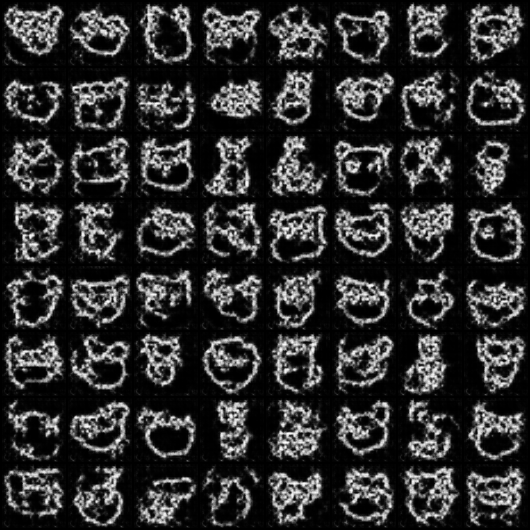



> DCGANs with **256** input noise dimension after **5 epochs training**.



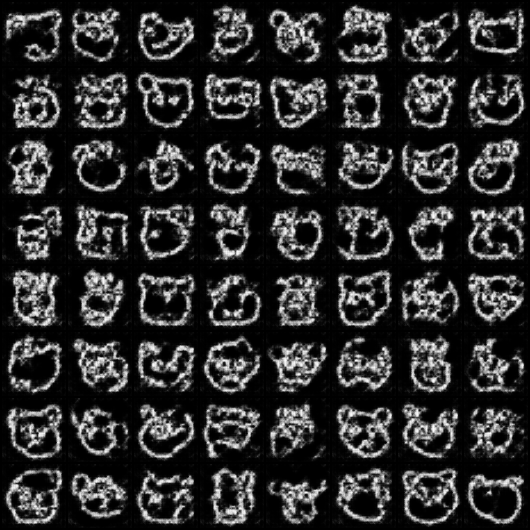

As shown above, DCGANs with 256 input noise dimension generate better fake images.

### 4.   Comparing network architecture
To figure out the importance of using nn.LeakyReLU as the activation function at the discriminator, here I experiment on discriminators with different activation function. After training those models, we use them to generate images which are regard as the performance of the model.

In [ ]:
class Discriminator_ReLU(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_ReLU, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.ReLU(True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, x, range(self.ngpu))
        else:
            output = self.main(x)

        return output.view(-1, 1).squeeze(1)

In [ ]:
for D in [Discriminator, Discriminator_ReLU]:
    netD = D(ngpu).to(device)
    netD.apply(weights_init)
    netG = Generator(ngpu).to(device)
    netG.apply(weights_init)
    train()



> DCGANs with regular discriminator using **nn.LeakyReLU** as the activation function generate fake images after **5 epochs training**.



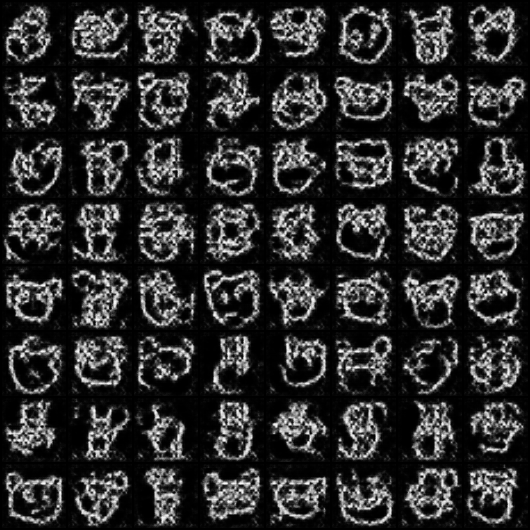



> DCGANs with the discriminator using **nn.ReLU** as the activation function generate fake images after **2 epochs training**.



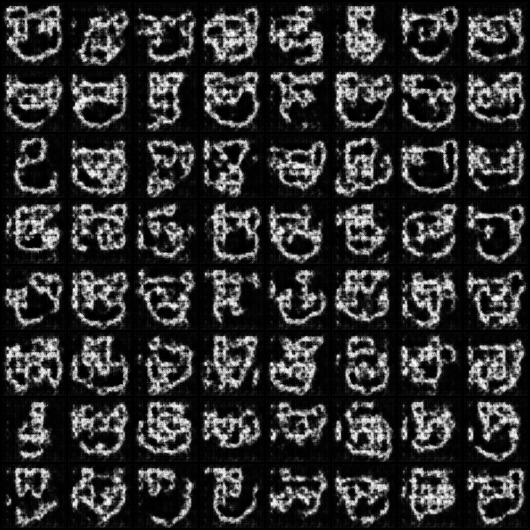



> DCGANs with the discriminator using **nn.ReLU** as the activation function generate fake images after **4 epochs training**.



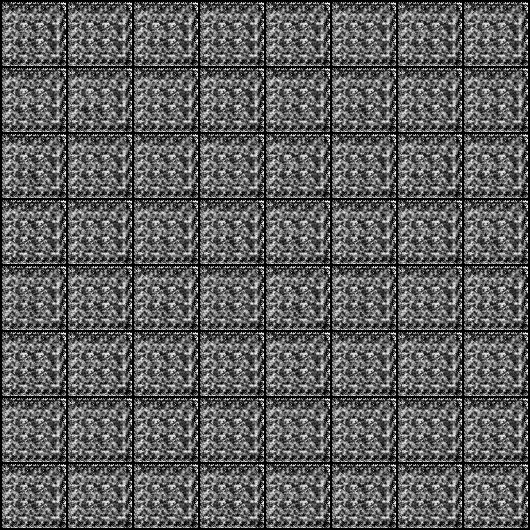

As shown above, DCGANs with regular discriminator generates good fake images after training. Although at first DCGANs with the discriminator using nn.ReLU also generate fake images that are not bad, it turns out to generate nonsense fake images at the end, which is caused the **vanishing gradient** of discriminator I discussed before. Thus, we need to use nn.LeakyReLU as the activation function (or other functions that have similar functionality) at the discriminator.

### 5.   Generate fake images
Here I generate fake images by saved trained model.

In [ ]:
nz = 256
model = Generator(ngpu).to(device)
model.load_state_dict(torch.load('./GANs_samples/netG_epoch_4_256.pth'))
noise = torch.randn(64, nz, 1, 1, device=device)
fake_images = model.forward(noise)
vutils.save_image(fake_images.detach(), './GANs_samples/fake_images.png', normalize=True)



> Fake images



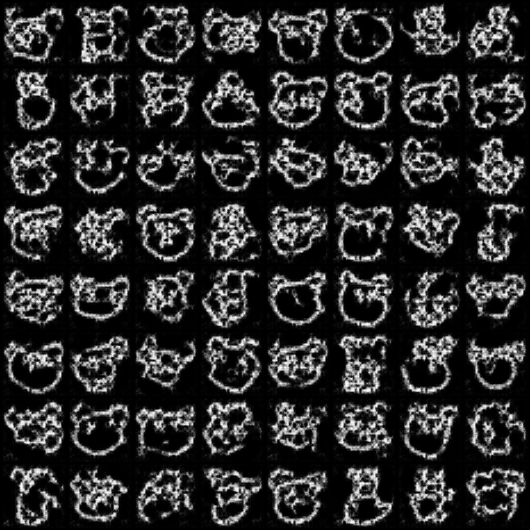



> Real images



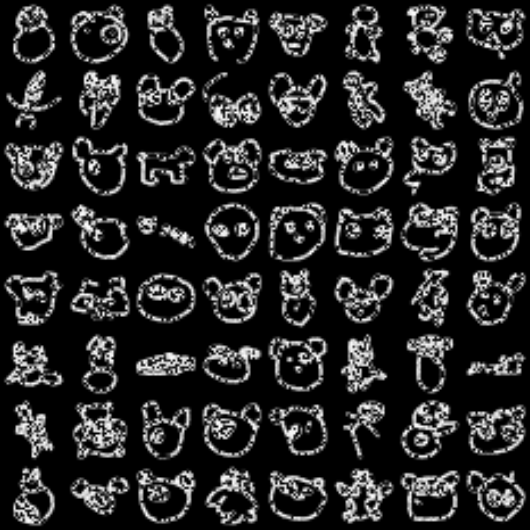

As shown below, DCGANs didn't generate very good fake images, but since there are a lot of difference between real images at dataset, I think the faker images it generated are not bad.

### 5.   Conclusion
The model with **256 input noise dimension** and discriminator with **LeakyReLU activation function** generates the best fake images.

Besides, DCGANs are indeed **generative**, it can generate pretty good fake images. However, it really depends on the dataset used for training. 

## Reference


1.   Phillip Lippe - Tutorial 9: Deep Autoencoders.[link](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html)

2.   Python Engineer - Autoencoder In PyTorch - Theory & Implementation.[link](https://www.youtube.com/watch?v=zp8clK9yCro)

3.   NYU_DeepLearning - Generative Models - Variational Autoencoders.[link](https://atcold.github.io/pytorch-Deep-Learning/en/week08/08-3/)

4.   Joseph Rocca - Understanding Variational Autoencoders (VAEs).[link](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

5.   NYU_DeepLearning - Generative Adversarial Networks.[link](https://atcold.github.io/pytorch-Deep-Learning/en/week09/09-3/)




## License
Copyright 2021 Gan Li

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.